In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from IPython.display import Image
import glob
import cv2
import seaborn as sns

<h2>Utility Functions</h2>

In [0]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

    
def get_outliers_row_idecies(df, name, sd):
    outliers_row_indecies = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    return outliers_row_indecies

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    

def read_images(path_images='drive/My Drive/Colab Notebooks/Houses Dataset/'):
    '''Loading images and creating Datafram'''
    
    img = pd.DataFrame()

    #Bathroom Image
    bathroom_images=[]
    for number in range(1, 536):
        for path in glob.glob(path_images + str(number) + "_bathroom.jpg"):
            if os.path.isfile(path):
                bathroom_images.append(path)

    img['Bathroom_img'] = bathroom_images
    
    #Bedroom Image
    bedroom_images=[]
    for number in range(1, 536):
        for path in glob.glob(path_images + str(number) + "_bedroom.jpg"):
            if os.path.isfile(path):
                bedroom_images.append(path)

    img['Bedroom_img'] = bedroom_images
    
    #FrontalImage
    frontal_images=[]
    for number in range(1, 536):
        for path in glob.glob(path_images + str(number) + "_frontal.jpg"):
            if os.path.isfile(path):
                frontal_images.append(path)

    img['Frontal_img'] = frontal_images
    
    #Kitchen Image
    kitchen_images=[]
    for number in range(1, 536):
        for path in glob.glob(path_images + str(number) + "_kitchen.jpg"):
            if os.path.isfile(path):
                kitchen_images.append(path)

    img['Kitchen_img'] = kitchen_images
    
    return img



def concate_images(img):
    images_output=[]
    for row_index,row in img.iterrows():
        inputImages=[]
        outputImage = np.zeros((128, 128, 3), dtype="uint8")
        image_temp1 = cv2.imread(row.Bathroom_img)
        image1 = cv2.resize(image_temp1, (64 , 64))

        image_temp2 = cv2.imread(row.Bedroom_img)
        image2 = cv2.resize(image_temp2, (64 , 64))

        image_temp3 = cv2.imread(row.Frontal_img)
        image3 = cv2.resize(image_temp3, (64 , 64))

        image_temp4 = cv2.imread(row.Kitchen_img)
        image4 = cv2.resize(image_temp4, (64 , 64))

        inputImages.append(image1)
        inputImages.append(image2)
        inputImages.append(image3)
        inputImages.append(image4)

        outputImage[0:64, 0:64] = inputImages[0]
        outputImage[0:64, 64:128] = inputImages[1]
        outputImage[64:128, 64:128] = inputImages[2]
        outputImage[64:128, 0:64] = inputImages[3]


        images_output.append(outputImage)
    return images_output


<h2>Importing Textual Data and Preprocessing</h2>

In [0]:
file_ = os.path.join('drive/My Drive/Colab Notebooks/Houses Dataset/HousesInfo.txt')

In [0]:
cols = ['Bedrooms', 'Bathrooms', 'Area', 'Zipcode', 'Price']

In [0]:
data = pd.read_csv(file_, sep=' ', header=None, names=cols, na_values=[None, 'NA', '-', ' '])

In [7]:
data.head()

,Bedrooms,Bathrooms,Area,Zipcode,Price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [8]:
data.shape

(535, 5)

In [9]:
data.isna().sum()

Bedrooms     0
Bathrooms    0
Area         0
Zipcode      0
Price        0
dtype: int64

<h2>Importing and Preprocessing Image Data</h2>

In [0]:
img = read_images()

In [11]:
img.shape

(535, 4)

In [12]:
img.head()

,Bathroom_img,Bedroom_img,Frontal_img,Kitchen_img
0,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...
1,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...
2,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...
3,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...
4,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...,drive/My Drive/Colab Notebooks/Houses Dataset/...


In [0]:
images_combined = concate_images(img)

In [14]:
type(images_combined)

list

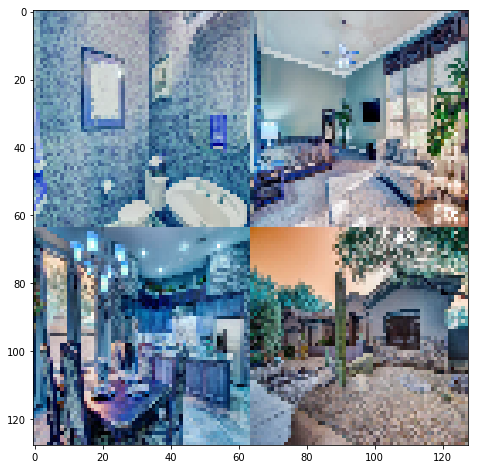

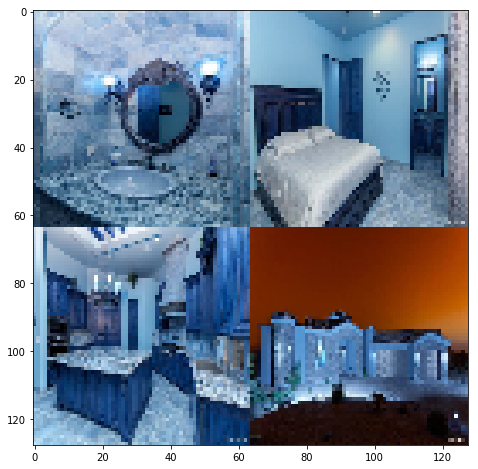

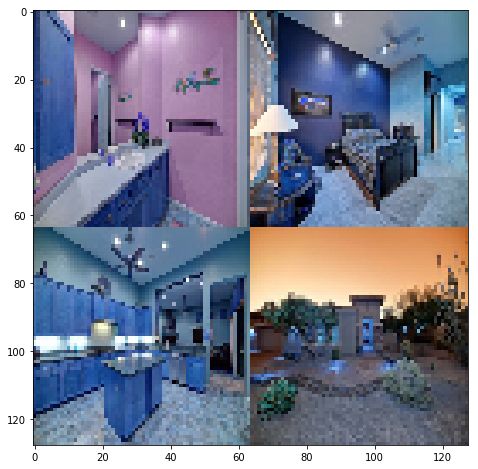

In [15]:
i=0;
for image in images_combined:
    if i==3:
        break
    i += 1
    plt.figure(figsize=(8,8))
    plt.imshow(image, interpolation='nearest')
    plt.show()

In [16]:
img_arr=np.asarray(images_combined).astype(np.float32)
print(type(img_arr))
print(img_arr.dtype)
img_arr.shape

<class 'numpy.ndarray'>
float32


(535, 128, 128, 3)

<h2>Finding Outliers for Price using Box Plot</h2>

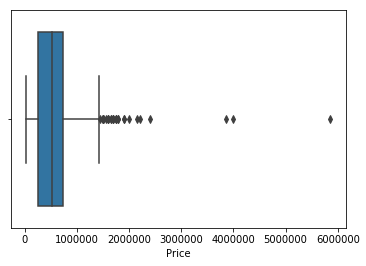

In [17]:
sns.boxplot(x=data['Price'])

In [18]:
price_std = data.loc[:,'Price'].std()
price_std

509026.06764905644

In [19]:
outliers_row_indices = get_outliers_row_idecies(data,'Price',1.5)
outliers_row_indices

Int64Index([  7,   8,   9,  20,  21,  23,  28,  33,  86, 109, 125, 130, 136,
            148, 149, 150, 156, 168, 170, 172, 185, 186, 215, 216, 220, 223,
            226, 255, 261, 266, 395, 421, 485, 499],
           dtype='int64')

In [0]:
#removing outliers rows from data and img_arr
data.drop(outliers_row_indices, axis=0, inplace=True)
img_arr = np.delete(img_arr, outliers_row_indices, axis=0)

In [21]:
data.shape, img_arr.shape

((501, 5), (501, 128, 128, 3))

<h2>Verifying Outliers are removed</h2>

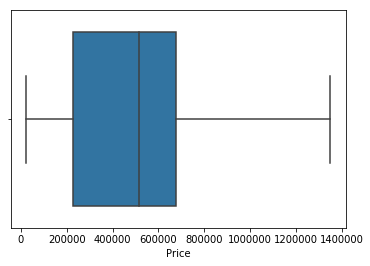

In [22]:
sns.boxplot(x=data['Price'])

In [23]:
data.shape, img_arr.shape

((501, 5), (501, 128, 128, 3))

<h2>Seperating Input and Output Columns</h2>

In [0]:
data_y = pd.DataFrame()
data_y['Price'] = data['Price']

In [0]:
data_x = data.drop(columns=['Price'], inplace=False)

In [26]:
data_x.head()

,Bedrooms,Bathrooms,Area,Zipcode
0,4,4.0,4053,85255
1,4,3.0,3343,36372
2,3,4.0,3923,85266
3,5,5.0,4022,85262
4,3,4.0,4116,85266


In [27]:
print(type(data_y))
data_y.head()

<class 'pandas.core.frame.DataFrame'>


,Price
0,869500
1,865200
2,889000
3,910000
4,971226


In [28]:
max_price = data_y['Price'].max()
print(max_price)

1350000


<h2>Data Normalization and One Hot Encoding for Textual Data</h2>

In [0]:
#Applying z-score to numeric data
encode_numeric_zscore(data_x,'Bedrooms')
encode_numeric_zscore(data_x,'Bathrooms')
encode_numeric_zscore(data_x,'Area')

In [30]:
data_x.shape

(501, 4)

In [0]:
#Applying One-hot Encoding to Categorical Data
encode_text_dummy(data_x,'Zipcode')

In [32]:
print(data_x.shape)
data_x.head()

(501, 49)


,Bedrooms,Bathrooms,Area,Zipcode-36372,Zipcode-60002,Zipcode-60016,Zipcode-60046,Zipcode-62025,Zipcode-62034,Zipcode-62088,Zipcode-62214,Zipcode-62234,Zipcode-62249,Zipcode-81418,Zipcode-81521,Zipcode-81524,Zipcode-85255,Zipcode-85262,Zipcode-85266,Zipcode-85331,Zipcode-85377,Zipcode-90803,Zipcode-91752,Zipcode-91901,Zipcode-91915,Zipcode-92021,Zipcode-92040,Zipcode-92253,Zipcode-92276,Zipcode-92543,Zipcode-92677,Zipcode-92692,Zipcode-92802,Zipcode-92880,Zipcode-93105,Zipcode-93111,Zipcode-93314,Zipcode-93446,Zipcode-93510,Zipcode-93720,Zipcode-93924,Zipcode-94501,Zipcode-94531,Zipcode-94565,Zipcode-94568,Zipcode-95008,Zipcode-95220,Zipcode-96019,Zipcode-98021
0,0.583695,1.519170,1.542439,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.583695,0.447569,0.929796,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.281486,1.519170,1.430265,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.448877,2.590770,1.515690,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.281486,1.519170,1.596801,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h2>Splitting data into training and testing dataset</h2>
<ul>
    <li>Converting into numpy array</li>
    <li>Splitting into training and testing dataset by 70% and 30% ratio</li>
</ul>

In [0]:
x = data_x.to_numpy(dtype=np.float32)
y = data_y.to_numpy(dtype=np.float32)

In [34]:
x.shape, y.shape

((501, 49), (501, 1))

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, img_train, img_test = train_test_split(x, y, img_arr, test_size=0.3, random_state=42)
#img_train, img_test = train_test_split(img_arr, test_size=0.2, shuffle=False, stratify=None)

In [36]:
x_train.shape, y_train.shape

((350, 49), (350, 1))

In [37]:
x_test.shape, y_test.shape

((151, 49), (151, 1))

In [38]:
img_train.shape, img_test.shape

((350, 128, 128, 3), (151, 128, 128, 3))

<h2>Image Normalization and Scaling Price</h2>
<ul>
    <li>Verifying image pixel range is 0-255</li>
    <li>Normalizing image dividing by 255</li>
    <li>Scaling Price by dividing by max_price</li>
</ul>

In [39]:
#Verifying image pixel range
print(img_train.min(), img_train.max())
print(img_test.min(), img_test.max())

0.0 255.0
0.0 255.0


In [0]:
#Normalizing Image
img_train /= 255
img_test /= 255

In [41]:
print(img_train.min(), img_train.max())
print(img_test.min(), img_test.max())
print(img_train.shape, img_test.shape)

0.0 1.0
0.0 1.0
(350, 128, 128, 3) (151, 128, 128, 3)


In [42]:
#Checking max Price is less or equal to max_price
print(y_train.max(), y_test.max())
print(max_price)

1350000.0 1349000.0
1350000


In [0]:
#Scaling Price diding by max_price
y_train /= max_price
y_test /= max_price

In [44]:
print(y_train.max(), y_test.max())

1.0 0.99925923


<h2>Creating Multiple Input Model using Keras Functional API</h2>

In [45]:
from sklearn import metrics
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)

for i in range(0,5):
  # CNN model for Images
  cnn_input = Input(shape=img_train.shape[1:])
  conv_layer1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(cnn_input)
  pooling_layer1 = MaxPooling2D(pool_size=(2, 2))(conv_layer1)

  conv_layer2 = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(pooling_layer1)
  pooling_layer2 = MaxPooling2D(pool_size=(2, 2))(conv_layer2)


  conv_layer3 = Conv2D(16, kernel_size=(3,3), strides=(1,1) , padding='same', activation='relu')(pooling_layer2)
  pooling_layer3 = MaxPooling2D(pool_size=(2, 2))(conv_layer3)
  cnn_output = Flatten()(pooling_layer3)

  #cnn_dense_layer1 = Dense(8, activation='relu')(flatten_layer)
  #dropout_layer = Dropout(0.5)(cnn_dense_layer1)
  #cnn_output = Dense(4, activation='relu')(dropout_layer)


  # Dense Layers for Textual Data
  dense_input = Input(shape=(x_train.shape[1],))
  dense_layer_1 = Dense(64, activation='relu')(dense_input)
  dense_layer_2 = Dense(32, activation='relu')(dense_layer_1)
  dense_output = Dense(16, activation='relu')(dense_layer_2)


  # merge input models
  merge = concatenate([cnn_output,dense_output])

  # Final layers
  hidden1 = Dense(16, activation='relu')(merge)
  #hidden2 = Dense(8, activation='relu')(hidden1)
  output = Dense(1)(hidden1)

  model = Model(inputs = [cnn_input,dense_input], outputs = output)

  model.compile(loss='mean_squared_error', optimizer='adam')
  
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

   #Model Summary
  print(model.summary())

  model.fit([img_train,x_train],y_train, validation_data=([img_test,x_test],y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=200)  

  #Plotting Model
  #plot_model(model, to_file='drive/My Drive/Colab Notebooks/multiple_inputs.png')


Using TensorFlow backend.







Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   18464       max_pooling2d_1[0][0]            
_______________________________________________________________________________________

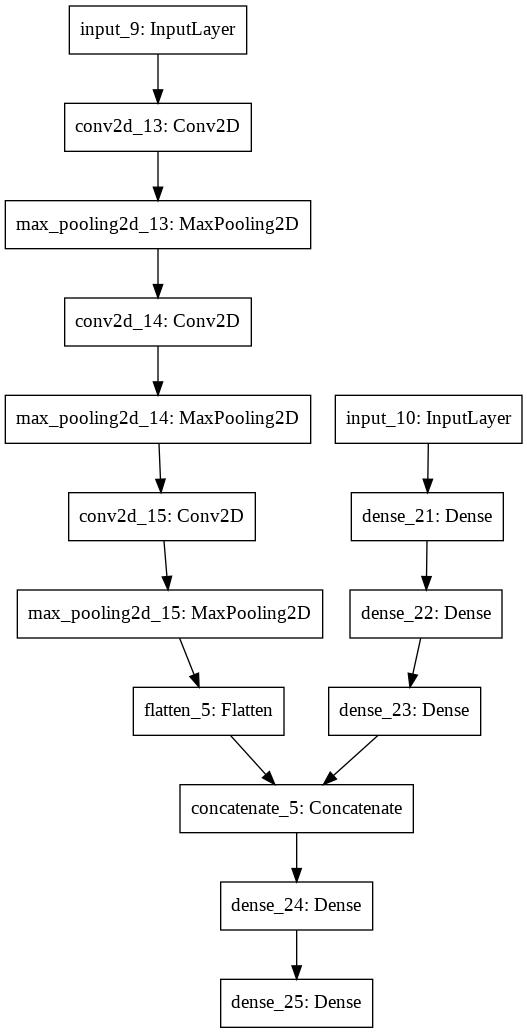

In [46]:
#Plotting Model
plot_model(model, to_file='drive/My Drive/Colab Notebooks/multiple_inputs.png')

#model.fit([img_train,x_train],y_train, validation_data=([img_test,x_test],y_test), callbacks=[monitor,checkpointer],verbose=2,epochs=200)
#model.load_weights('best_weights.hdf5')

In [0]:
model.load_weights('best_weights.hdf5')
pred = model.predict([img_test,x_test])
pred *= max_price
y_test *= max_price

RMSE: 152460.5625
R2 Score: 0.7575704893053345


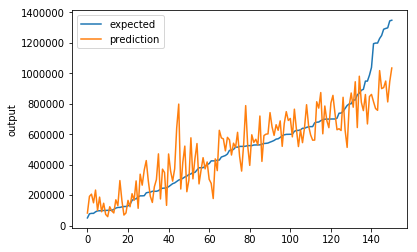

In [48]:
# Measure RMSE error.  RMSE is common for regression.
rmse = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("RMSE: {}".format(rmse))

_r2_score = metrics.r2_score(y_test,pred)
print("R2 Score: {}".format(_r2_score))

# Lift Chart
chart_regression(pred.flatten(),y_test,sort=True)